In [1]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tqdm import tqdm
from scipy.special import kl_div
import gc
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import pandas as pd
from copy import deepcopy

import torch
from torch.nn import functional
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from torch.optim.lr_scheduler import _LRScheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
from torchvision.models.feature_extraction import create_feature_extractor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

import sys
sys.path.append('../')
from utils import *

# sys.path.append('../SSD/')
# import importlib
# importlib.reload(ssd)
# import ssd as ssd

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
batch_size = 256

# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)
forget_idx = random.sample(list(forget_idx),600)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]
retain_idx = random.sample(list(retain_idx),29400)

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader_not_shuffle = torch.utils.data.DataLoader(
    forget_set, batch_size=batch_size, shuffle=False, drop_last=False
)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=batch_size, shuffle=True, drop_last=True
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=batch_size, shuffle=True, generator=RNG, drop_last=True
)

In [4]:
def remove_retain_similar_to_forget(feats_retain_df, feats_forget_df, batch_size=64, similarity_metric='cosine', similarity_pct=0.1):
    features_retain = feats_retain_df.iloc[:,1:].values
    features_forget = feats_forget_df.iloc[:,1:].values

    # Compute max similarity
    max_similarity = np.empty(features_retain.shape[0])
    for i in range(0, features_retain.shape[0], 512):
        batch_features_retain = features_retain[i:i+512]
        if similarity_metric=='euclidean':
            similarity_matrix = euclidean_distances(batch_features_retain, features_forget)
            max_similarity[i:i+512] = np.min(similarity_matrix, axis=1)
            top_X_pct_idx = np.argsort(max_similarity)[:int(similarity_pct * len(max_similarity))]
        elif similarity_metric=='cosine':
            similarity_matrix = cosine_similarity(batch_features_retain, features_forget)
            max_similarity[i:i+512] = np.max(similarity_matrix, axis=1)
            top_X_pct_idx = np.argsort(max_similarity)[-int(similarity_pct * len(max_similarity)):]

    # Get X% of data points
    similar_df = feats_retain_df.iloc[top_X_pct_idx]
    similar_ids_set = set(top_X_pct_idx)
    
    include_indices = [i for i,data_id in enumerate(feats_retain_df['unique_id']) if data_id not in similar_ids_set]
    filtered_dataset = Subset(retain_loader.dataset, include_indices)
    
    return DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

In [5]:
def reduce_dataset(
    net, 
    retain_loader, 
    forget_loader,
    similarity_pct
):
    
    '''
    Feature extraction
    '''
    
    feat_extractor = create_feature_extractor(net, {'avgpool': 'feat1'})
    
    '''
    Get class weights
    '''
    
    # Retain logits
    list_of_targets = []
    start_idx = 0
    data = np.empty((len(retain_loader.dataset), 513), dtype=object)
    idx = 0
    
    with torch.no_grad():
        for sample in retain_loader:
            # Get logits
            targets = sample[1]
            list_of_targets.append(np.array(targets))
            
            # Feature extraction
            inputs = sample[0]
            person_id = sample[1]
            image_id = sample[1]
            outputs = feat_extractor(inputs.to(DEVICE))['feat1']
            feats = torch.flatten(outputs, start_dim=1)
        
            for i in range(len(targets)):
                data[idx] = [str(person_id[i])+'-'+str(image_id[i])] + feats[i].cpu().numpy().tolist()
                idx +=1
            
    retain_class_weights = torch.tensor(1/np.bincount(np.concatenate(list_of_targets).ravel())).to(DEVICE, dtype=torch.float32)
       
    columns = ['unique_id'] + [f'feat_{i}' for i in range(512)]
    feats_retain_df = pd.DataFrame(data, columns=columns)
    
    # Forget logits
    list_of_targets = []
    start_idx = 0
    data = np.empty((len(forget_loader.dataset), 513), dtype=object)
    idx = 0
    
    with torch.no_grad():
        for sample in forget_loader:
            # Get logits
            targets = sample[1]
            list_of_targets.append(np.array(targets))
            
            # Feature extraction
            inputs = sample[0]
            person_id = sample[1]
            image_id = sample[1]
            outputs = feat_extractor(inputs.to(DEVICE))['feat1']
            feats = torch.flatten(outputs, start_dim=1)
        
            for i in range(len(targets)):
                data[idx] = [str(person_id[i])+'-'+str(image_id[i])] + feats[i].cpu().numpy().tolist()
                idx +=1
            
    forget_class_weights = torch.tensor(1/np.bincount(np.concatenate(list_of_targets).ravel())).to(DEVICE, dtype=torch.float32)
       
    columns = ['unique_id'] + [f'feat_{i}' for i in range(512)]
    feats_forget_df = pd.DataFrame(data, columns=columns)
    
    '''
    Reduce retain dataset
    '''
    
    retain_loader = remove_retain_similar_to_forget(feats_retain_df, feats_forget_df, batch_size=retain_loader.batch_size, similarity_metric='euclidean', similarity_pct=similarity_pct)
    
    return retain_class_weights, forget_class_weights, retain_loader

In [6]:
# local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
local_path = "../example notebooks/weights/internal_weights_resnet18_cifar10.pth"

if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs
# weights_pretrained = torch.load("../checkpoints/0.pt", map_location=DEVICE)

# load model with pre-trained weights
net = resnet18(weights=None, num_classes=10)
try:
    net.load_state_dict(weights_pretrained)
except:
    net.load_state_dict(weights_pretrained['net'])
net.to(DEVICE)
net.eval();

RAR = accuracy(net, retain_loader)
TAR = accuracy(net, test_loader)

In [7]:
# Reduce retain set and calculate class weights
# retain_class_weights, forget_class_weights, retain_loader = reduce_dataset(net, retain_loader, forget_loader, similarity_pct=0.20)

In [8]:
def calculate_loss(model, inputs, targets):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        loss = torch.nn.CrossEntropyLoss(reduction="none")(outputs, targets)
    return loss.detach().cpu().numpy()

In [9]:
def average_gradient_from_loader(model, optimizer, loader, num_batches):
    last_linear_layer = model.fc
    avg_grad = None
    criterion = nn.CrossEntropyLoss()
    
    count = 0
    for i, (data, target) in enumerate(loader):
        if i >= num_batches:
            break
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        if avg_grad is None:
            avg_grad = last_linear_layer.weight.grad.clone()
        else:
            avg_grad += last_linear_layer.weight.grad.clone()

        count +=1

        return avg_grad / count

# Calculate losses from trained from scratch

In [10]:
original_losses = [[] for _ in range(len(forget_loader.dataset))]

for checkpoint in os.listdir('../unlearn metric/checkpoints/'):

    weights_pretrained = torch.load(f"../unlearn metric/checkpoints/{checkpoint}", map_location=DEVICE)
    try:
        net.load_state_dict(weights_pretrained['net'])
    except:
        net.load_state_dict(weights_pretrained['model_state_dict'])
    net.to(DEVICE)
    net.eval();

    run_losses = []

    for inputs, targets in forget_loader_not_shuffle:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        batch_losses = calculate_loss(net, inputs, targets)
        run_losses.extend(batch_losses)

    for idx, loss in enumerate(run_losses):
        original_losses[idx].append(loss)

# Unlearn

In [11]:
# Function to inject noise into the model's weights
def inject_noise(model, noise_level=0.01):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:
                noise = torch.randn_like(param) * param.abs() * noise_level
                param.add_(noise)
            elif 'bias' in name:
                noise = torch.randn_like(param) * param.abs() * noise_level
                param.add_(noise)

In [12]:
def inject_decay_noise(model, base_noise_level, decay_rate, global_step, min_noise_level=1e-6):
    with torch.no_grad():
        decayed_noise_level = max(base_noise_level * (decay_rate ** global_step), min_noise_level)
        if decayed_noise_level <= min_noise_level:
            return  # Skip noise injection if the level is below the threshold
        for name, param in model.named_parameters():
            if 'weight' in name:
                noise = torch.randn_like(param) * decayed_noise_level * param.abs()
                param.add_(noise)
            elif 'bias' in name:
                noise = torch.randn_like(param) * decayed_noise_level * param.abs()
                param.add_(noise)

In [13]:
class ReverseCosineAnnealingLR(_LRScheduler):
    def __init__(self, optimizer, T_max, last_epoch=-1, eta_min=0):
        self.T_max = T_max
        self.eta_min = eta_min
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [
            self.eta_min
            + (
                0.5
                * (base_lr - self.eta_min)
                * (1 + math.cos(math.pi * (1 - (self.last_epoch) / self.T_max)))
            )
            for base_lr in self.base_lrs
        ]

In [14]:
def rewind(net, retain_loader, forget_loader, LR, epochs=1, noise_level=0):

    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-3)
    scheduler = ReverseCosineAnnealingLR(optimizer, T_max=30*(len(retain_loader)+1))

    net.train()

    for _ in range(epochs):

        retain_not_depleted = True
        iter_retain = iter(retain_loader)
        
        if noise_level>0:
            inject_noise(net, noise_level=noise_level)

        # Retain rewind
        while retain_not_depleted:
            try:
                sample = next(iter_retain)
            except StopIteration:
                retain_not_depleted = False
                break

            inputs, targets = sample
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = -1.0*criterion(outputs, targets)
            loss.backward()

            # nn.utils.clip_grad_value_(net.parameters(), 2)

            optimizer.step()
            scheduler.step()

        # Forget rewind
        for _ in range(4):

            forget_not_depleted = True
            iter_forget = iter(forget_loader)

            while forget_not_depleted:
                try:
                    sample = next(iter_forget)
                except StopIteration:
                    forget_not_depleted = False
                    break

                inputs, targets = sample
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = -1.0*criterion(outputs, targets)
                loss.backward()

                # nn.utils.clip_grad_value_(net.parameters(), 2)

                optimizer.step()
                scheduler.step()

        # print(f'Forget acc: {accuracy(net, forget_loader)}')
        # print(f'Test acc: {accuracy(net, test_loader)}')


    return optimizer.param_groups[0]['lr']

In [15]:
def retrain_slow(net, retain, initial_lr=0.1, noise_level=0.2, epochs=1, steps_per_epoch=len(retain_loader)):

    current_batch = 0
    warmup_batches = steps_per_epoch//2
    global_step = 0

    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
    optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*len(retain_loader))

    net.train()

    if noise_level>0:
        inject_noise(net, noise_level=noise_level)

    for ep in range(epochs):

        for inputs, targets in retain:

            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            current_batch += 1

            # Warm-up for the first 'warmup_batches' batches
            if current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            # nn.utils.clip_grad_value_(net.parameters(), 2)
            
            optimizer.step()
            global_step += 1

            # if global_step>=steps_per_epoch:
            #     break

            scheduler.step()

In [16]:
class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = functional.log_softmax(y_s/self.T, dim=1)
        p_t = functional.softmax(y_t/self.T, dim=1)
        loss = functional.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

In [42]:
class SCRUBTraining:
    def __init__(self, teacher, student, retain_dataloader, forget_dataloader, K=4.0, LR=0.01):
        self.teacher = teacher
        self.student = student
        self.retain_dataloader = retain_dataloader
        self.forget_dataloader = forget_dataloader
        self.LR = LR
        self.K = K

        self.criterion_cls = nn.CrossEntropyLoss()
        self.criterion_div = DistillKL(K)
        self.criterion_kd = DistillKL(K)

        self.optimizer = optim.SGD(student.parameters(), lr=LR, momentum=0.9, weight_decay=5e-3)

    def train_epoch(self):
        self.student.train()
        self.teacher.eval()

        # Function to compute accuracy.
        def compute_accuracy(outputs, labels):
            _, predicted = outputs.max(1)
            total = labels.size(0)
            correct = predicted.eq(labels).sum().item()
            return 100 * correct / total

        total_loss_retain, total_accuracy_retain = 0, 0
        total_loss_forget, total_accuracy_forget = 0, 0
        counter = 0
        # Training with retain data.
        for inputs_retain, labels_retain in self.retain_dataloader:
            inputs_retain, labels_retain = inputs_retain.cuda(), labels_retain.cuda()

            # Forward pass: Student
            outputs_retain_student = self.student(inputs_retain)

            # Forward pass: Teacher
            with torch.no_grad():
                outputs_retain_teacher = self.teacher(inputs_retain)

            # Loss computation
            loss_cls = self.criterion_cls(outputs_retain_student, labels_retain)
            loss_div_retain = self.criterion_div(outputs_retain_student, outputs_retain_teacher)

            loss = loss_cls + loss_div_retain

            # Update total loss and accuracy for retain data.
            # total_loss_retain += loss.item()
            # total_accuracy_retain += compute_accuracy(outputs_retain_student, labels_retain)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_value_(self.student.parameters(), 2)
            self.optimizer.step()

            counter += 1
            if counter > 20:
                break

        # Training with forget data.
        for inputs_forget, labels_forget in self.forget_dataloader:
            inputs_forget, labels_forget = inputs_forget.cuda(), labels_forget.cuda()

            # Forward pass: Student
            outputs_forget_student = self.student(inputs_forget)

            # Forward pass: Teacher
            with torch.no_grad():
                outputs_forget_teacher = self.teacher(inputs_forget)

            # We want to maximize the divergence for the forget data.
            loss_div_forget = -self.criterion_div(outputs_forget_student, outputs_forget_teacher)

            # Update total loss and accuracy for forget data.
            # total_loss_forget += loss_div_forget.item()
            # total_accuracy_forget += compute_accuracy(outputs_forget_student, labels_forget)

            # Backward pass
            self.optimizer.zero_grad()
            loss_div_forget.backward()
            # nn.utils.clip_grad_value_(self.student.parameters(), 2)
            self.optimizer.step()

        # # Print average loss and accuracy for the entire epoch
        # avg_loss_retain = total_loss_retain / len(self.retain_dataloader)
        # avg_accuracy_retain = total_accuracy_retain / len(self.retain_dataloader)

        # avg_loss_forget = total_loss_forget / len(self.forget_dataloader)
        # avg_accuracy_forget = total_accuracy_forget / len(self.forget_dataloader)

        # print(f'Epoch Retain: Avg Loss: {avg_loss_retain:.4f}, Avg Accuracy: {avg_accuracy_retain:.2f}%')
        # print(f'Epoch Forget: Avg Loss: {avg_loss_forget:.4f}, Avg Accuracy: {avg_accuracy_forget:.2f}%')

In [18]:
class SCRUBAdvancedTraining:
    def __init__(self, teacher, student, retain_dataloader, forget_dataloader, K=4.0, LR=0.01):
        self.teacher = teacher
        self.student = student
        self.retain_dataloader = retain_dataloader
        self.forget_dataloader = forget_dataloader
        self.LR = LR
        self.K = K

        self.criterion_cls = nn.CrossEntropyLoss()
        self.criterion_div = DistillKL(K)
        self.criterion_kd = DistillKL(K)

        self.optimizer = optim.SGD(student.parameters(), lr=LR, momentum=0.9, weight_decay=5e-3)

    def train_epoch(self):
        self.student.train()
        self.teacher.eval()

        # Function to compute accuracy.
        def compute_accuracy(outputs, labels):
            _, predicted = outputs.max(1)
            total = labels.size(0)
            correct = predicted.eq(labels).sum().item()
            return 100 * correct / total

        total_loss_retain, total_accuracy_retain = 0, 0
        total_loss_forget, total_accuracy_forget = 0, 0

        # Training with retain data.
        for inputs_retain, labels_retain in self.retain_dataloader:
            inputs_retain, labels_retain = inputs_retain.cuda(), labels_retain.cuda()

            iter_forget = iter(forget_loader)
            inputs_forget, labels_forget = next(iter_forget)
            inputs_forget, labels_forget = inputs_forget.cuda(), labels_forget.cuda()

            # Forward pass: Student
            outputs_retain_student = self.student(inputs_retain)
            outputs_forget_student = self.student(inputs_forget)

            # Forward pass: Teacher
            with torch.no_grad():
                outputs_retain_teacher = self.teacher(inputs_retain)
                outputs_forget_teacher = self.teacher(inputs_forget)

            # Loss computation
            loss_cls = self.criterion_cls(outputs_retain_student, labels_retain)
            loss_div_retain = self.criterion_div(outputs_retain_student, outputs_retain_teacher)
            loss_div_forget = -self.criterion_div(outputs_forget_student, outputs_forget_teacher)

            retain_loss = loss_cls + loss_div_retain 
            joint_loss = retain_loss + loss_div_forget

            # Update total loss and accuracy for retain data.
            total_loss_retain += retain_loss.item()
            total_accuracy_retain += compute_accuracy(outputs_retain_student, labels_retain)

            # Update total loss and accuracy for forget data.
            total_loss_forget += loss_div_forget.item()
            total_accuracy_forget += compute_accuracy(outputs_forget_student, labels_forget)

            # Backward pass
            self.optimizer.zero_grad()
            joint_loss.backward()
            nn.utils.clip_grad_value_(self.student.parameters(), 10)
            self.optimizer.step()

        # Print average loss and accuracy for the entire epoch
        avg_loss_retain = total_loss_retain / len(self.retain_dataloader)
        avg_accuracy_retain = total_accuracy_retain / len(self.retain_dataloader)

        avg_loss_forget = total_loss_forget / len(self.retain_dataloader)
        avg_accuracy_forget = total_accuracy_forget / len(self.retain_dataloader)

        print(f'Epoch Retain: Avg Loss: {avg_loss_retain:.4f}, Avg Accuracy: {avg_accuracy_retain:.2f}%')
        print(f'Epoch Forget: Avg Loss: {avg_loss_forget:.4f}, Avg Accuracy: {avg_accuracy_forget:.2f}%')

In [19]:
# # Load original model
# weights_pretrained = torch.load(local_path, map_location=DEVICE)
# original_model = resnet18(weights=None, num_classes=10)
# original_model.load_state_dict(weights_pretrained)
# original_model.to(DEVICE)
# original_model.train()

# scrub_model = deepcopy(original_model)
# scrub_model.to(DEVICE)
# scrub_model.train()
# unstructure_prune(net, pruning_amount=0.5, global_pruning=True, random_init=False, only_fc=False)
# # inject_noise(net, noise_level=0.1)
# # scrub_model.fc.reset_parameters()


In [20]:
# teacher = original_model
# student = scrub_model

# # Initialize and train
# intermid_lr = rewind(student, retain_loader, forget_loader, 0.01, epochs=3)
# inject_noise(student, noise_level=0.1)
# student.fc.reset_parameters()
# scrub_trainer = SCRUBTraining(teacher, student, retain_loader, forget_loader, 0.01)

# num_epochs = 15
# for epoch in range(num_epochs):
#     scrub_trainer.train_epoch()
#     print(f"Epoch {epoch+1} completed.")

# Calculate losses from unlearn model

In [21]:
# Clean
gc.collect()
torch.cuda.empty_cache()

In [53]:
X = len(os.listdir('../unlearn metric/checkpoints/'))  # number of times to run the unlearning algorithm
unlearn_losses = [[] for _ in range(len(forget_loader.dataset))]  # List of lists to hold losses per sample index
forget_accs = []
test_accs = []
retain_accs = []

for i in tqdm(range(1)):
    
    # Load original model
    weights_pretrained = torch.load(local_path, map_location=DEVICE)
    teacher = resnet18(weights=None, num_classes=10)
    try:
        teacher.load_state_dict(weights_pretrained)
    except:
        teacher.load_state_dict(weights_pretrained['net'])
    teacher.to(DEVICE)
    teacher.train()

    student = deepcopy(teacher)
    student.to(DEVICE)
    student.train()


    # scrub_trainer = SCRUBAdvancedTraining(teacher, student, retain_loader, forget_loader, LR=LR_)

    # for _ in range(scrubs_epochs):
    #     scrub_trainer.train_epoch()

    # Hyperparams
    batch_size = 256
    noise_level = 0.25
    pruning_amount = 0
    scrubs_lr = 1e-4
    reset_fc = False
    scrubs_epochs = 1
    
    # # Prune
    # if pruning_amount>0:
    #     unstructure_prune(student, pruning_amount=pruning_amount, global_pruning=True, random_init=False, only_fc=False)
    
    # # Unlearn
    # if reset_fc:
    #     student.fc.reset_parameters()
        
    # if noise_level>0:
    inject_noise(student, noise_level=0.25)
    # print(accuracy(student, retain_loader))
    scrub_trainer = SCRUBTraining(teacher, student, retain_loader, forget_loader, LR=scrubs_lr)

    for _ in range(scrubs_epochs):

        scrub_trainer.train_epoch()
        print('...........')
        print(f'Forget acc: {accuracy(student, forget_loader)}')
        print(f'Test acc: {accuracy(student, test_loader)}')

    # inject_noise(student, noise_level=0.25)
    # retrain_slow(student, retain_loader, 1e-4, noise_level=noise_level, epochs=1)


    student.eval()
    run_losses = []

    for inputs, targets in forget_loader_not_shuffle:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        batch_losses = calculate_loss(student, inputs, targets)
        run_losses.extend(batch_losses)

    for idx, loss in enumerate(run_losses):
        unlearn_losses[idx].append(loss)

    # Calc metrics
    retain_accs.append(accuracy(student, retain_loader))
    forget_accs.append(accuracy(student, forget_loader))
    test_accs.append(accuracy(student, test_loader))

    # Clean
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/1 [00:00<?, ?it/s]

...........
Forget acc: 0.982421875
Test acc: 0.7702


100%|██████████| 1/1 [00:11<00:00, 11.65s/it]


In [54]:
print(f'Retain acc: {retain_accs[-1]}')
print(f'Forget acc: {forget_accs[-1]}')
print(f'Test acc: {test_accs[-1]}')

Retain acc: 0.9887609649122807
Forget acc: 0.98046875
Test acc: 0.7718


# Metrics

### Accuracy

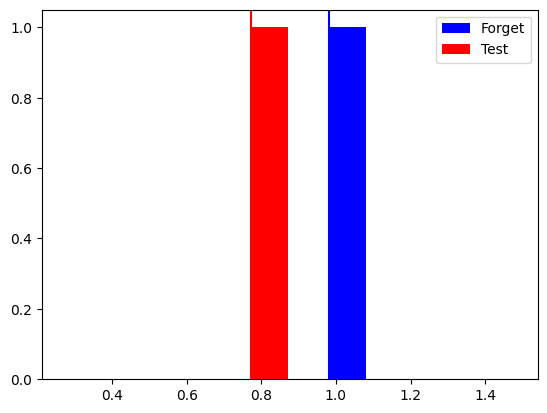

In [55]:
plt.hist(forget_accs, color='blue', label='Forget')
plt.axvline(x=np.mean(forget_accs), color='blue')
plt.hist(test_accs, color='red', label='Test')
plt.axvline(x=np.mean(test_accs), color='red')
plt.legend()
plt.show()

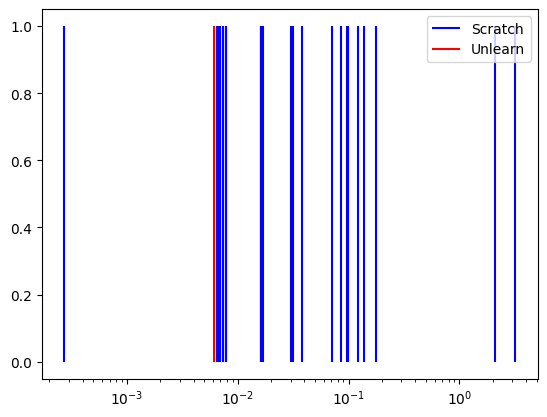

In [56]:
idx = 100
plt.vlines(original_losses[idx], ymin=0, ymax=1, color='blue', label='Scratch')
plt.vlines(unlearn_losses[idx], ymin=0, ymax=1, color='red', label='Unlearn')
plt.xscale('log')
plt.legend()
plt.show()

## Simple MIA

In [57]:
acc_scores = []

for idx, original_loss in enumerate(original_losses):
    acc_scores.append(simple_mia(original_loss, unlearn_losses[idx], n_splits=10, random_state=0).mean())

plt.hist(acc_scores, bins=50, log=True)
plt.title(f'Simple MIA, mean={np.mean(acc_scores):.2f}, median={np.median(acc_scores):.2f}');

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## Paper forget score

In [ ]:
f = forgetting_quality(
    unlearn_losses,
    original_losses,
    attacks=[tree_attack, best_threshold_attack, logistic_regression_attack],
    delta=0.01)
f

Computing F...: 100%|██████████| 25/25 [00:00<00:00, 92.72it/s]


0.284384765625

In [ ]:
RA_ratio = np.mean(retain_accs) / RAR
TA_ratio = np.mean(test_accs) / TAR
print(f'Final score: {f * RA_ratio * TA_ratio}')

Final score: 0.2732452084121151


### KL

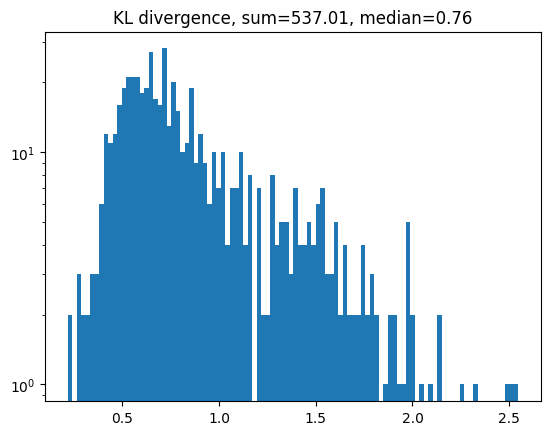

In [ ]:
kl_losses = []
epsilon = 1e-2

for idx, original_loss in enumerate(original_losses):
    # losses_from_scratch = np.log(np.array(original_loss)/2 + epsilon)
    # losses_unlearn = np.log(np.array(unlearn_losses[idx]) + epsilon)

    # losses_from_scratch = np.random.lognormal(mean=losses_from_scratch.mean(), sigma=losses_from_scratch.std(), size=1000)
    # losses_unlearn = np.random.lognormal(mean=losses_unlearn.mean(), sigma=losses_unlearn.std(), size=1000)

    losses_from_scratch = np.array(original_loss)
    # losses_unlearn = np.array(unlearn_losses[idx])
    losses_unlearn = random.sample(unlearn_losses[idx], len(losses_from_scratch))

    # Ensure all losses are non-negative (they should naturally be if they are losses)
    # assert np.all(losses_from_scratch >= 0) and np.all(losses_unlearn >= 0), "Losses must be non-negative"

    # Normalize the losses to sum to one to represent probability distributions
    prob_dist_scratch = losses_from_scratch / np.sum(losses_from_scratch)
    prob_dist_unlearn = losses_unlearn / np.sum(losses_unlearn)

    prob_dist_scratch += epsilon
    prob_dist_unlearn += epsilon

    # Normalize again after adding epsilon to ensure they sum to one
    prob_dist_scratch /= np.sum(prob_dist_scratch)
    prob_dist_unlearn /= np.sum(prob_dist_unlearn)

    # Calculate the KL divergence from scratch to unlearn
    kl_divergence = kl_div(prob_dist_scratch, prob_dist_unlearn)

    # Sum over all elements to get the total divergence
    total_kl_divergence = np.sum(kl_divergence)

    kl_losses.append(total_kl_divergence)

plt.hist(kl_losses, bins=100, log=True)
plt.title(f'KL divergence, sum={np.sum(kl_losses):.2f}, median={np.median(kl_losses):.2f}')
plt.show()

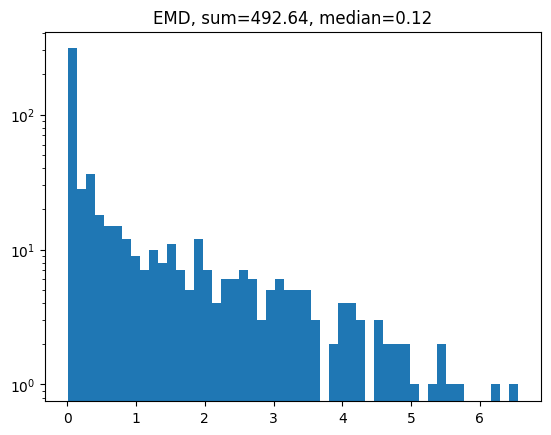

In [ ]:
# Normalize losses, calculate standard deviation, and EMD per sample
emd_scores = []

for idx, original_loss in enumerate(original_losses):
   
    # Calculate Earth Mover's Distance
    emd_score = wasserstein_distance(original_loss, unlearn_losses[idx])
    emd_scores.append(emd_score)

plt.hist(emd_scores, bins=50, log=True)
plt.title(f'EMD, sum={np.sum(emd_scores):.2f}, median={np.median(emd_scores):.2f}');

In [ ]:
# j = 0
# plt.hist(losses_from_scratch, color='blue', label='Trained from scratch')
# plt.axvline(x=np.mean(losses_from_scratch), color='blue')
# plt.hist(losses_unlearn, color='red', label='Unlearn')
# plt.axvline(x=np.mean(losses_unlearn), color='red')
# plt.yscale('log')
# plt.legend()
# plt.show()